In [1]:
import random
from datetime import datetime
from simulation import Simulation

random.seed(datetime.now().timestamp())
num_reps = 100

all_results = []
all_labs = []

for _ in range(num_reps):
    sim = Simulation(sample_arrival_mean=5, end_time=360, num_doctors=3)
    results = sim.run()
    all_results.append(results)
    all_labs.append(sim.lab)

In [2]:
avg_processed = sum(r['processed_samples'] for r in all_results) / num_reps
avg_remaining = sum(r['remaining_samples'] for r in all_results) / num_reps
avg_total = sum(r['total_samples'] for r in all_results) / num_reps

print("\n=== PRIEMERNÉ ŠTATISTIKY HISTOPATOLOGICKÉHO PRACOVISKA ===")
print(f"Spracovaných vzoriek (priemer): {avg_processed:.2f}")
print(f"Nespracovaných vzoriek (priemer): {avg_remaining:.2f}")
print(f"Celkový počet vzoriek (priemer): {avg_total:.2f}")


=== PRIEMERNÉ ŠTATISTIKY HISTOPATOLOGICKÉHO PRACOVISKA ===
Spracovaných vzoriek (priemer): 70.55
Nespracovaných vzoriek (priemer): 0.67
Celkový počet vzoriek (priemer): 71.22


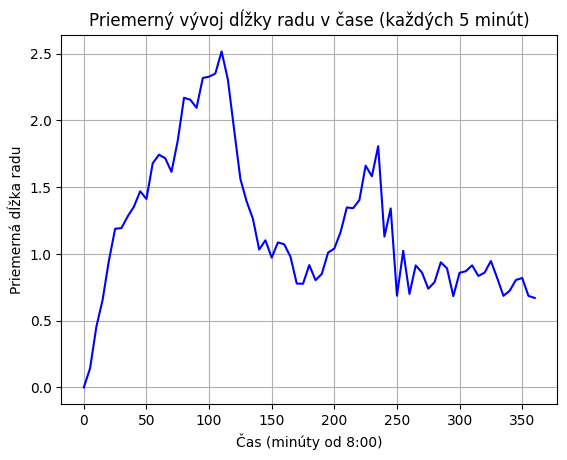


=== Priemerna doba čakania na posúdenie ===
Priemerná doba čakania: 9.20 minút


In [3]:
import matplotlib.pyplot as plt
from collections import defaultdict

interval = 5  # 5 minútové intervaly
queue_lengths_by_time = defaultdict(list)

for lab in all_labs:
    for time, q_len in zip(lab.queue_times, lab.queue_lengths):
        rounded_time = int(time // interval * interval)
        queue_lengths_by_time[rounded_time].append(q_len)

average_queue_lengths = {
    t: sum(lengths) / len(lengths)
    for t, lengths in queue_lengths_by_time.items()
}

sorted_times = sorted(average_queue_lengths.keys())
sorted_averages = [average_queue_lengths[t] for t in sorted_times]

plt.plot(sorted_times, sorted_averages, color='blue')
plt.xlabel("Čas (minúty od 8:00)")
plt.ylabel("Priemerná dĺžka radu")
plt.title("Priemerný vývoj dĺžky radu v čase (každých 5 minút)")
plt.grid(True)
plt.show()

all_waiting_times = []
for lab in all_labs:
    if hasattr(lab, 'waiting_times') and lab.waiting_times:
        all_waiting_times.extend(lab.waiting_times)

print("\n=== Priemerna doba čakania na posúdenie ===")
if all_waiting_times:
    avg_wait = sum(all_waiting_times) / len(all_waiting_times)
    print(f"Priemerná doba čakania: {avg_wait:.2f} minút")
else:
    print("Žiadne vzorky nečakali v rade.")

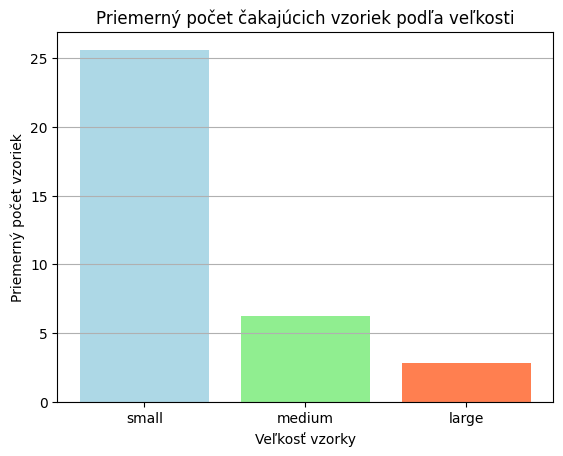


=== Priemerný počet čakajúcich vzoriek na posúdenie podľa typu ===
Small: 25.60 vzoriek
Medium: 6.23 vzoriek
Large: 2.81 vzoriek


In [4]:
from collections import Counter
import matplotlib.pyplot as plt

total_waiting_counts = Counter()
for lab in all_labs:
    waiting_sizes = [s.size.value for s in lab.waiting_samples]
    total_waiting_counts.update(waiting_sizes)

num_simulations = len(all_labs)
average_counts = {
    size: total_waiting_counts[size] / num_simulations
    for size in ['small', 'medium', 'large']
}

labels = ['small', 'medium', 'large']
counts = [average_counts.get(label, 0) for label in labels]

plt.bar(labels, counts, color=['lightblue', 'lightgreen', 'coral'])
plt.title("Priemerný počet čakajúcich vzoriek podľa veľkosti")
plt.xlabel("Veľkosť vzorky")
plt.ylabel("Priemerný počet vzoriek")
plt.grid(axis='y')
plt.show()

print("\n=== Priemerný počet čakajúcich vzoriek na posúdenie podľa typu ===")
for label in labels:
    print(f"{label.capitalize()}: {average_counts.get(label, 0):.2f} vzoriek")


=== Priemerný počet jednotlivých vzoriek ===
small: 49.56 (70.25%)
medium: 14.05 (19.91%)
large: 6.94 (9.84%)


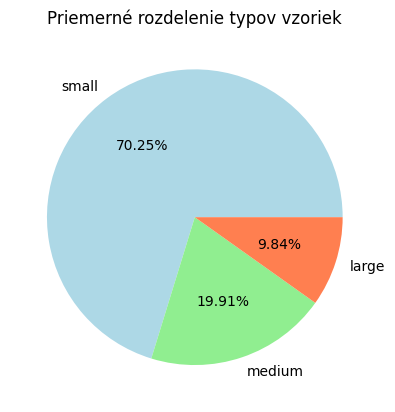

In [5]:
from collections import Counter
import matplotlib.pyplot as plt


total_sample_counts = Counter()
for lab in all_labs:
    sizes = [s.size.value for s in lab.processed_samples]
    total_sample_counts.update(sizes)

num_simulations = len(all_labs)
average_counts = {
    size: total_sample_counts[size] / num_simulations
    for size in ['small', 'medium', 'large']
}

total = sum(average_counts.values())
print("\n=== Priemerný počet jednotlivých vzoriek ===")
for size, count in average_counts.items():
    percentage = (count / total) * 100
    print(f"{size}: {count:.2f} ({percentage:.2f}%)")

# Vykreslenie koláčového grafu
plt.pie(average_counts.values(), labels=average_counts.keys(), autopct="%1.2f%%", colors=['lightblue', 'lightgreen', 'coral'])
plt.title("Priemerné rozdelenie typov vzoriek")
plt.show()

In [6]:
print("\n=== Priemerný počet vzoriek vyžadujúcich primára ===")

# Počet vzoriek, ktoré vyžadujú primára v každej simulácii
head_doctor_samples_all_simulations = []

for lab in all_labs:
    head_doctor_samples = sum(1 for sample in lab.processed_samples if sample.needs_head_doctor_review)
    head_doctor_samples_all_simulations.append(head_doctor_samples)

# Priemerný počet vzoriek vyžadujúcich primára
average_head_doctor_samples = sum(head_doctor_samples_all_simulations) / len(head_doctor_samples_all_simulations)
total_samples_all_simulations = sum(len(lab.processed_samples) for lab in all_labs)

print(f"Priemerný počet vzoriek vyžadujúcich primára: {average_head_doctor_samples:.2f}")


=== Priemerný počet vzoriek vyžadujúcich primára ===
Priemerný počet vzoriek vyžadujúcich primára: 5.02



=== Priemerná vyťaženosť jednotlivých lekárov ===
Lekár 1: 81.80%
Lekár 2: 75.05%
Lekár 3: 65.69%
Primár: 16.64%


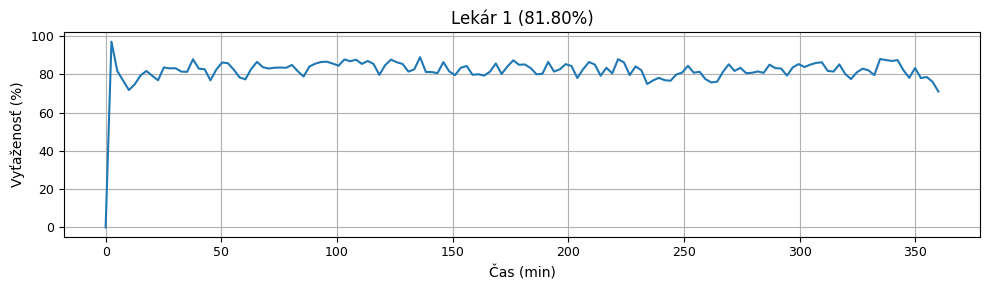

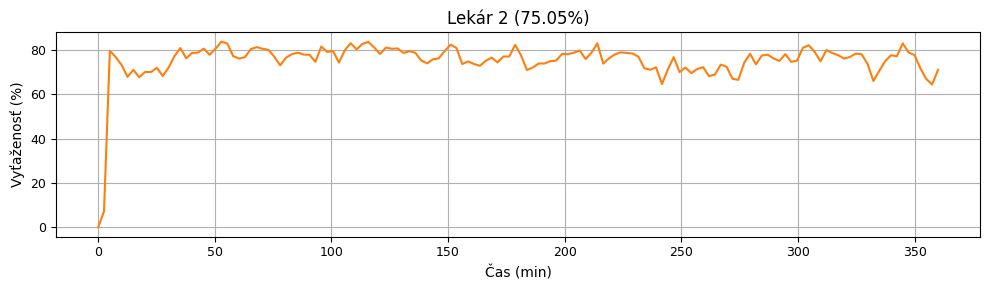

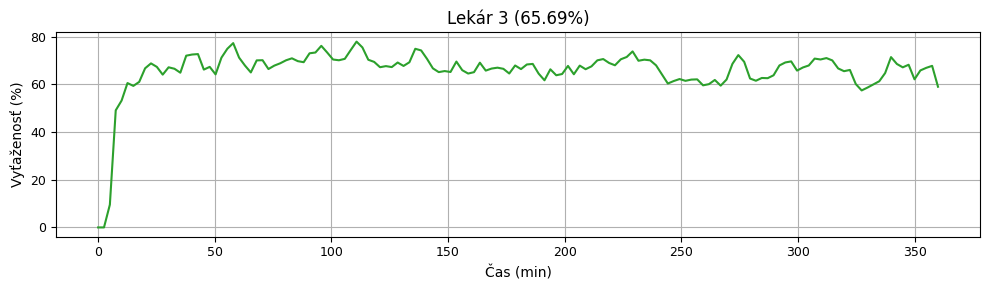

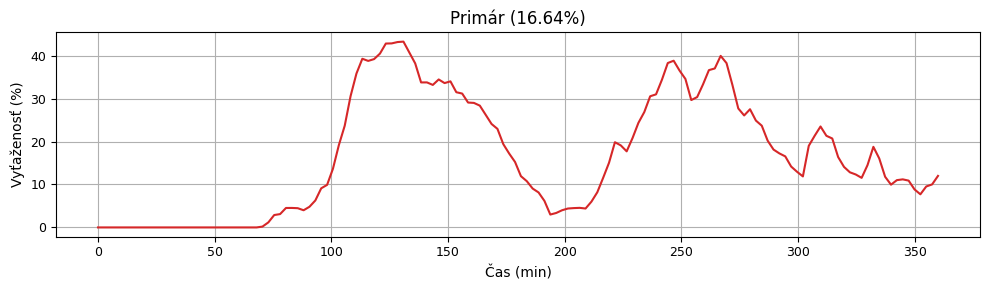

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Počet lekárov a časové body
num_doctors_total = len(lab.doctor_utilization[0])
total_time_points = len(lab.doctor_utilization)

average_doctor_utilization_all_simulations = [[] for _ in range(num_doctors_total)]
target_time_points = len(lab.utilization_times)
x_axis = np.linspace(0, lab.utilization_times[-1], target_time_points)

# Zber dát a interpolácia
for lab in all_labs:
    for doc_id in range(num_doctors_total):
        doctor_usage = [util[doc_id] for util in lab.doctor_utilization]
        if len(doctor_usage) != target_time_points:
            doctor_usage = np.interp(
                np.arange(target_time_points),
                np.linspace(0, target_time_points - 1, len(doctor_usage)),
                doctor_usage
            )
        average_doctor_utilization_all_simulations[doc_id].append(doctor_usage)

# Priemerné vyťaženosti
avg_utilization_per_doctor_across_simulations = [
    np.mean(util_list, axis=0)
    for util_list in average_doctor_utilization_all_simulations
]

print("\n=== Priemerná vyťaženosť jednotlivých lekárov ===")
for doc_id in range(num_doctors_total):
    avg_percent = np.mean(avg_utilization_per_doctor_across_simulations[doc_id]) * 100
    if doc_id < num_doctors_total - 1:
        print(f"Lekár {doc_id + 1}: {avg_percent:.2f}%")
    else:
        print(f"Primár: {avg_percent:.2f}%")

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'purple']
labels = [f"Lekár {i + 1}" for i in range(num_doctors_total - 1)] + ["Primár"]

# Vykreslenie grafov pod seba
for doc_id in range(num_doctors_total):
    y_values = avg_utilization_per_doctor_across_simulations[doc_id] * 100
    plt.figure(figsize=(10, 3))
    plt.plot(x_axis, y_values, color=colors[doc_id])
    plt.title(f"{labels[doc_id]} ({np.mean(y_values):.2f}%)")
    plt.xlabel("Čas (min)")
    plt.ylabel("Vyťaženosť (%)")
    plt.grid(True)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()